In [11]:
import re
import time
import gc
import random
import os
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 100)
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import operator
tqdm.pandas()

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [3]:
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [4]:
test_df.head()

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


In [8]:
print('Percentage of insincere questions in the training set {0:.2%}\n'.format((train_df['target']>=0.5).sum()/len(train_df)))

Percentage of insincere questions in the training set 8.00%



In [9]:
df_text = pd.concat([train_df['comment_text'], test_df['comment_text']])

In [12]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            if word in vocab:
                vocab[word] += 1
            else:
                vocab[word] = 1
    return vocab
vocab = build_vocab(df_text)

In [13]:
len(vocab)

1731089

In [14]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

mispell_dict = {"aren't" : "are not",
"can't" : "can not",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

In [15]:
def load_and_prec(df_text):
    '''
    # lower
    train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: x.lower())
    test_df["question_text"] = test_df["question_text"].progress_apply(lambda x: x.lower())
    '''
    
    # Clean speelings
    df_text = df_text.progress_apply(lambda x: replace_typical_misspell(x))
    
    # Clean the text
    df_text = df_text.progress_apply(lambda x: clean_text(x))
    
    '''
    # Clean numbers
    df_text["question_text"] = df_text["question_text"].progress_apply(lambda x: clean_numbers(x))
    '''
    
    '''
    ## fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values
    '''
    return df_text

In [16]:
load_and_prec(df_text)

100%|█████████████████████████████████████████████████████████████████████| 1902194/1902194 [00:49<00:00, 38193.00it/s]


0        This is so cool .  It ' s like ,   ' would you want your mother to read this ?  ?  '  Really gre...
1        Thank you !  !  This would make my life a lot less anxiety - inducing .  Keep it up ,  and do no...
2               This is such an urgent design problem ;  kudos to you for taking it on .  Very impressive ! 
3                 Is this something I ' ll be able to install on my site ?  When will you be releasing it ? 
4                                                                     haha you guys are a bunch of losers . 
5                                                                                   ur a sh * tty comment . 
6                                                                              hahahahahahahahhha suck it . 
7                                                                                        FFFFUUUUUUUUUUUUUUU
8        The ranchers seem motivated by mostly by greed ;  no one should have the right to allow their an...
9                  

In [17]:
tokenizer = Tokenizer(oov_token='_##_', filters='"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenizer.fit_on_texts(list(df_text))

In [19]:
train_X = tokenizer.texts_to_sequences(train_df['comment_text'].values)
test_X = tokenizer.texts_to_sequences(test_df['comment_text'].values)

In [20]:
train_df['text_sequence'] = train_X
test_df['text_sequence'] = test_X
train_df['sequence_length'] = train_df['text_sequence'].apply(lambda x: len(x))
test_df['sequence_length'] = test_df['text_sequence'].apply(lambda x: len(x))

In [21]:
train_df['sequence_length'].describe()

count    1.804874e+06
mean     5.192204e+01
std      4.663135e+01
min      0.000000e+00
25%      1.700000e+01
50%      3.600000e+01
75%      7.300000e+01
max      3.170000e+02
Name: sequence_length, dtype: float64

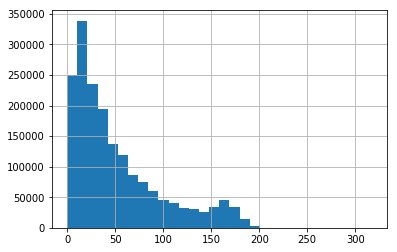

In [24]:
train_df['sequence_length'].hist(bins = 30)

In [25]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [38]:
df_text = pd.concat([train_df['comment_text'], test_df['comment_text']])

In [39]:
def load_and_prec_lower(df_text):
    
    # lower
    df_text = df_text.progress_apply(lambda x: x.lower())
    
    
    # Clean speelings
    df_text = df_text.progress_apply(lambda x: replace_typical_misspell(x))
    
    # Clean the text
    df_text = df_text.progress_apply(lambda x: clean_text(x))
    
    
    # Clean numbers
    df_text = df_text.progress_apply(lambda x: clean_numbers(x))
    
    
    '''
    ## fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values
    '''
    return df_text

In [44]:
df_text = load_and_prec_lower(df_text)



  0%|                                                                                      | 0/1902194 [00:00<?, ?it/s]

  0%|                                                                          | 1/1902194 [00:00<227:39:51,  2.32it/s]

  1%|▉                                                                     | 25480/1902194 [00:00<157:13:51,  3.32it/s]

  3%|█▊                                                                    | 48530/1902194 [00:00<108:42:37,  4.74it/s]

  4%|██▋                                                                    | 71950/1902194 [00:00<75:08:11,  6.77it/s]

  5%|███▌                                                                   | 94274/1902194 [00:00<51:57:17,  9.67it/s]

  6%|████▎                                                                 | 116592/1902194 [00:00<35:55:12, 13.81it/s]

  7%|█████▏                                                                | 141278/1902194 [00:01<24:47:49, 19.73it/s]

  9%|██████▏                  

  4%|██▋                                                                    | 71595/1902194 [00:02<00:50, 36608.58it/s]

  4%|██▊                                                                    | 75260/1902194 [00:02<00:50, 36004.42it/s]

  4%|██▉                                                                    | 78918/1902194 [00:02<00:50, 36097.27it/s]

  4%|███                                                                    | 82532/1902194 [00:02<00:50, 35926.92it/s]

  5%|███▏                                                                   | 86264/1902194 [00:02<00:50, 36253.53it/s]

  5%|███▎                                                                   | 89892/1902194 [00:02<00:50, 35861.51it/s]

  5%|███▍                                                                   | 93481/1902194 [00:02<00:51, 34956.88it/s]

  5%|███▋                                                                   | 97140/1902194 [00:02<00:51, 35358.63it/s]

  5%|███▋                       

 16%|███████████▌                                                          | 313388/1902194 [00:08<00:45, 35131.78it/s]

 17%|███████████▋                                                          | 316907/1902194 [00:08<00:45, 35074.26it/s]

 17%|███████████▊                                                          | 320610/1902194 [00:09<00:44, 35550.09it/s]

 17%|███████████▉                                                          | 324505/1902194 [00:09<00:43, 36430.88it/s]

 17%|████████████                                                          | 328248/1902194 [00:09<00:42, 36647.05it/s]

 17%|████████████▏                                                         | 331919/1902194 [00:09<00:43, 36048.47it/s]

 18%|████████████▎                                                         | 335531/1902194 [00:09<00:43, 35672.03it/s]

 18%|████████████▍                                                         | 339104/1902194 [00:09<00:44, 35505.63it/s]

 18%|████████████▌              

 30%|████████████████████▉                                                 | 567864/1902194 [00:15<00:35, 37706.58it/s]

 30%|█████████████████████                                                 | 571637/1902194 [00:15<00:35, 37606.98it/s]

 30%|█████████████████████▏                                                | 575480/1902194 [00:15<00:35, 37768.68it/s]

 30%|█████████████████████▎                                                | 579259/1902194 [00:15<00:35, 37354.60it/s]

 31%|█████████████████████▍                                                | 583040/1902194 [00:16<00:35, 37408.47it/s]

 31%|█████████████████████▌                                                | 586849/1902194 [00:16<00:35, 37515.88it/s]

 31%|█████████████████████▋                                                | 590655/1902194 [00:16<00:34, 37596.56it/s]

 31%|█████████████████████▊                                                | 594416/1902194 [00:16<00:34, 37518.40it/s]

 31%|██████████████████████     

 43%|██████████████████████████████                                        | 816747/1902194 [00:22<00:30, 35988.98it/s]

 43%|██████████████████████████████▏                                       | 820472/1902194 [00:22<00:29, 36280.71it/s]

 43%|██████████████████████████████▎                                       | 824151/1902194 [00:22<00:29, 36353.10it/s]

 44%|██████████████████████████████▍                                       | 827962/1902194 [00:22<00:29, 36777.57it/s]

 44%|██████████████████████████████▌                                       | 831808/1902194 [00:22<00:28, 37175.88it/s]

 44%|██████████████████████████████▋                                       | 835567/1902194 [00:22<00:28, 37216.70it/s]

 44%|██████████████████████████████▉                                       | 839291/1902194 [00:23<00:28, 36704.40it/s]

 44%|███████████████████████████████                                       | 843101/1902194 [00:23<00:28, 37033.18it/s]

 45%|███████████████████████████

 56%|██████████████████████████████████████▋                              | 1067209/1902194 [00:29<00:21, 38212.19it/s]

 56%|██████████████████████████████████████▊                              | 1071075/1902194 [00:29<00:21, 38261.12it/s]

 57%|██████████████████████████████████████▉                              | 1075004/1902194 [00:29<00:21, 38482.37it/s]

 57%|███████████████████████████████████████▏                             | 1078856/1902194 [00:29<00:21, 37844.73it/s]

 57%|███████████████████████████████████████▎                             | 1082646/1902194 [00:29<00:21, 37333.44it/s]

 57%|███████████████████████████████████████▍                             | 1086457/1902194 [00:29<00:21, 37481.90it/s]

 57%|███████████████████████████████████████▌                             | 1090211/1902194 [00:29<00:21, 37420.66it/s]

 58%|███████████████████████████████████████▋                             | 1094027/1902194 [00:30<00:21, 37555.22it/s]

 58%|███████████████████████████

 70%|████████████████████████████████████████████████▏                    | 1327304/1902194 [00:36<00:15, 37506.16it/s]

 70%|████████████████████████████████████████████████▎                    | 1331058/1902194 [00:36<00:15, 37322.84it/s]

 70%|████████████████████████████████████████████████▍                    | 1334864/1902194 [00:36<00:15, 37446.33it/s]

 70%|████████████████████████████████████████████████▌                    | 1338611/1902194 [00:36<00:15, 37259.54it/s]

 71%|████████████████████████████████████████████████▋                    | 1342448/1902194 [00:36<00:14, 37506.25it/s]

 71%|████████████████████████████████████████████████▊                    | 1346479/1902194 [00:36<00:14, 38225.93it/s]

 71%|████████████████████████████████████████████████▉                    | 1350433/1902194 [00:36<00:14, 38528.39it/s]

 71%|█████████████████████████████████████████████████▏                   | 1354290/1902194 [00:36<00:14, 37342.58it/s]

 71%|███████████████████████████

 83%|█████████████████████████████████████████████████████████▍           | 1583720/1902194 [00:42<00:08, 37795.77it/s]

 83%|█████████████████████████████████████████████████████████▌           | 1587523/1902194 [00:43<00:08, 37783.27it/s]

 84%|█████████████████████████████████████████████████████████▋           | 1591488/1902194 [00:43<00:08, 38226.56it/s]

 84%|█████████████████████████████████████████████████████████▉           | 1595582/1902194 [00:43<00:07, 38919.59it/s]

 84%|██████████████████████████████████████████████████████████           | 1599479/1902194 [00:43<00:07, 38378.41it/s]

 84%|██████████████████████████████████████████████████████████▏          | 1603322/1902194 [00:43<00:07, 37970.90it/s]

 84%|██████████████████████████████████████████████████████████▎          | 1607124/1902194 [00:43<00:07, 37678.01it/s]

 85%|██████████████████████████████████████████████████████████▍          | 1610896/1902194 [00:43<00:07, 37608.25it/s]

 85%|███████████████████████████

 97%|██████████████████████████████████████████████████████████████████▊  | 1842706/1902194 [00:49<00:01, 36066.90it/s]

 97%|██████████████████████████████████████████████████████████████████▉  | 1846323/1902194 [00:49<00:01, 35597.70it/s]

 97%|███████████████████████████████████████████████████████████████████  | 1849892/1902194 [00:50<00:01, 35544.24it/s]

 97%|███████████████████████████████████████████████████████████████████▏ | 1853507/1902194 [00:50<00:01, 35649.93it/s]

 98%|███████████████████████████████████████████████████████████████████▎ | 1857214/1902194 [00:50<00:01, 35984.73it/s]

 98%|███████████████████████████████████████████████████████████████████▌ | 1860900/1902194 [00:50<00:01, 36165.37it/s]

 98%|███████████████████████████████████████████████████████████████████▋ | 1864520/1902194 [00:50<00:01, 35673.49it/s]

 98%|███████████████████████████████████████████████████████████████████▊ | 1868279/1902194 [00:50<00:00, 36148.78it/s]

 98%|███████████████████████████

 10%|██████▋                                                               | 181106/1902194 [00:04<00:48, 35830.96it/s]

 10%|██████▊                                                               | 184902/1902194 [00:05<00:47, 36367.58it/s]

 10%|██████▉                                                               | 188786/1902194 [00:05<00:46, 37001.15it/s]

 10%|███████                                                               | 192532/1902194 [00:05<00:46, 37053.63it/s]

 10%|███████▏                                                              | 196334/1902194 [00:05<00:45, 37258.61it/s]

 11%|███████▎                                                              | 200243/1902194 [00:05<00:45, 37709.79it/s]

 11%|███████▌                                                              | 204164/1902194 [00:05<00:44, 38066.48it/s]

 11%|███████▋                                                              | 208005/1902194 [00:05<00:44, 38075.29it/s]

 11%|███████▊                   

 23%|███████████████▉                                                      | 432004/1902194 [00:11<00:40, 36478.86it/s]

 23%|████████████████                                                      | 435708/1902194 [00:11<00:40, 36566.37it/s]

 23%|████████████████▏                                                     | 439442/1902194 [00:11<00:39, 36715.92it/s]

 23%|████████████████▎                                                     | 443252/1902194 [00:12<00:39, 37041.36it/s]

 23%|████████████████▍                                                     | 447010/1902194 [00:12<00:39, 37123.79it/s]

 24%|████████████████▌                                                     | 450724/1902194 [00:12<00:40, 36180.59it/s]

 24%|████████████████▋                                                     | 454504/1902194 [00:12<00:39, 36573.95it/s]

 24%|████████████████▊                                                     | 458236/1902194 [00:12<00:39, 36715.26it/s]

 24%|█████████████████          

 36%|█████████████████████████▏                                            | 684466/1902194 [00:18<00:32, 37344.07it/s]

 36%|█████████████████████████▎                                            | 688201/1902194 [00:18<00:32, 37145.71it/s]

 36%|█████████████████████████▍                                            | 691917/1902194 [00:18<00:32, 36845.78it/s]

 37%|█████████████████████████▌                                            | 695678/1902194 [00:18<00:32, 36991.68it/s]

 37%|█████████████████████████▋                                            | 699456/1902194 [00:18<00:32, 37144.58it/s]

 37%|█████████████████████████▉                                            | 703249/1902194 [00:19<00:32, 37288.48it/s]

 37%|██████████████████████████                                            | 707019/1902194 [00:19<00:32, 37329.76it/s]

 37%|██████████████████████████▏                                           | 710753/1902194 [00:19<00:32, 36382.11it/s]

 38%|██████████████████████████▎

 49%|██████████████████████████████████▎                                   | 932883/1902194 [00:25<00:26, 37150.27it/s]

 49%|██████████████████████████████████▍                                   | 936609/1902194 [00:25<00:26, 37101.96it/s]

 49%|██████████████████████████████████▌                                   | 940380/1902194 [00:25<00:25, 37201.71it/s]

 50%|██████████████████████████████████▋                                   | 944156/1902194 [00:25<00:25, 37286.57it/s]

 50%|██████████████████████████████████▉                                   | 947894/1902194 [00:25<00:25, 37236.03it/s]

 50%|███████████████████████████████████                                   | 951632/1902194 [00:25<00:25, 37194.93it/s]

 50%|███████████████████████████████████▏                                  | 955377/1902194 [00:25<00:25, 37188.53it/s]

 50%|███████████████████████████████████▎                                  | 959212/1902194 [00:26<00:25, 37450.57it/s]

 51%|███████████████████████████

 62%|███████████████████████████████████████████                          | 1186848/1902194 [00:32<00:18, 38054.62it/s]

 63%|███████████████████████████████████████████▏                         | 1190720/1902194 [00:32<00:18, 38157.78it/s]

 63%|███████████████████████████████████████████▎                         | 1194558/1902194 [00:32<00:18, 38140.59it/s]

 63%|███████████████████████████████████████████▍                         | 1198422/1902194 [00:32<00:18, 38206.34it/s]

 63%|███████████████████████████████████████████▌                         | 1202244/1902194 [00:32<00:18, 37903.63it/s]

 63%|███████████████████████████████████████████▋                         | 1206036/1902194 [00:32<00:18, 37048.49it/s]

 64%|███████████████████████████████████████████▉                         | 1209778/1902194 [00:32<00:18, 37078.64it/s]

 64%|████████████████████████████████████████████                         | 1213564/1902194 [00:32<00:18, 37229.33it/s]

 64%|███████████████████████████

 76%|████████████████████████████████████████████████████▏                | 1439842/1902194 [00:39<00:12, 37248.76it/s]

 76%|████████████████████████████████████████████████████▎                | 1443737/1902194 [00:39<00:12, 37663.51it/s]

 76%|████████████████████████████████████████████████████▌                | 1447694/1902194 [00:39<00:11, 38135.18it/s]

 76%|████████████████████████████████████████████████████▋                | 1451513/1902194 [00:39<00:12, 37181.19it/s]

 77%|████████████████████████████████████████████████████▊                | 1455342/1902194 [00:39<00:11, 37426.59it/s]

 77%|████████████████████████████████████████████████████▉                | 1459199/1902194 [00:39<00:11, 37681.59it/s]

 77%|█████████████████████████████████████████████████████                | 1462982/1902194 [00:39<00:11, 37643.36it/s]

 77%|█████████████████████████████████████████████████████▏               | 1466750/1902194 [00:39<00:11, 36378.55it/s]

 77%|███████████████████████████

 89%|█████████████████████████████████████████████████████████████▏       | 1688242/1902194 [00:45<00:05, 35728.45it/s]

 89%|█████████████████████████████████████████████████████████████▎       | 1691816/1902194 [00:45<00:05, 35337.54it/s]

 89%|█████████████████████████████████████████████████████████████▍       | 1695352/1902194 [00:46<00:05, 34646.56it/s]

 89%|█████████████████████████████████████████████████████████████▋       | 1698938/1902194 [00:46<00:05, 34926.93it/s]

 90%|█████████████████████████████████████████████████████████████▊       | 1702600/1902194 [00:46<00:05, 35343.33it/s]

 90%|█████████████████████████████████████████████████████████████▉       | 1706138/1902194 [00:46<00:05, 34861.31it/s]

 90%|██████████████████████████████████████████████████████████████       | 1709685/1902194 [00:46<00:05, 34965.94it/s]

 90%|██████████████████████████████████████████████████████████████▏      | 1713309/1902194 [00:46<00:05, 35262.98it/s]

 90%|███████████████████████████

  2%|█▏                                                                     | 30665/1902194 [00:00<00:42, 43976.88it/s]

  2%|█▎                                                                     | 35536/1902194 [00:00<00:41, 45203.39it/s]

  2%|█▌                                                                     | 40343/1902194 [00:00<00:40, 45930.76it/s]

  2%|█▋                                                                     | 45197/1902194 [00:01<00:39, 46585.29it/s]

  3%|█▊                                                                     | 50215/1902194 [00:01<00:38, 47509.38it/s]

  3%|██                                                                     | 55517/1902194 [00:01<00:37, 48922.79it/s]

  3%|██▎                                                                    | 60585/1902194 [00:01<00:37, 49332.23it/s]

  3%|██▍                                                                    | 65593/1902194 [00:01<00:37, 49446.99it/s]

  4%|██▋                        

 19%|█████████████▏                                                        | 359256/1902194 [00:07<00:31, 49091.04it/s]

 19%|█████████████▍                                                        | 364323/1902194 [00:07<00:31, 49448.88it/s]

 19%|█████████████▌                                                        | 369285/1902194 [00:07<00:31, 49382.88it/s]

 20%|█████████████▊                                                        | 374226/1902194 [00:07<00:31, 49283.69it/s]

 20%|█████████████▉                                                        | 379187/1902194 [00:07<00:30, 49256.23it/s]

 20%|██████████████▏                                                       | 384218/1902194 [00:08<00:30, 49461.58it/s]

 20%|██████████████▎                                                       | 389166/1902194 [00:08<00:30, 49215.53it/s]

 21%|██████████████▌                                                       | 394114/1902194 [00:08<00:30, 49183.14it/s]

 21%|██████████████▋            

 37%|█████████████████████████▌                                            | 695222/1902194 [00:14<00:24, 48415.35it/s]

 37%|█████████████████████████▊                                            | 700066/1902194 [00:14<00:24, 48173.96it/s]

 37%|█████████████████████████▉                                            | 704885/1902194 [00:14<00:24, 48072.19it/s]

 37%|██████████████████████████                                            | 709694/1902194 [00:14<00:25, 47688.52it/s]

 38%|██████████████████████████▎                                           | 714465/1902194 [00:14<00:25, 47168.40it/s]

 38%|██████████████████████████▍                                           | 719185/1902194 [00:14<00:25, 46933.78it/s]

 38%|██████████████████████████▋                                           | 723881/1902194 [00:14<00:25, 46823.45it/s]

 38%|██████████████████████████▊                                           | 728646/1902194 [00:15<00:24, 46966.89it/s]

 39%|██████████████████████████▉

 54%|█████████████████████████████████████▏                               | 1026376/1902194 [00:21<00:17, 51090.33it/s]

 54%|█████████████████████████████████████▍                               | 1031754/1902194 [00:21<00:16, 51758.74it/s]

 55%|█████████████████████████████████████▌                               | 1036933/1902194 [00:21<00:16, 51659.54it/s]

 55%|█████████████████████████████████████▊                               | 1042102/1902194 [00:21<00:16, 51551.52it/s]

 55%|█████████████████████████████████████▉                               | 1047259/1902194 [00:21<00:16, 50987.28it/s]

 55%|██████████████████████████████████████▏                              | 1052361/1902194 [00:21<00:16, 50434.47it/s]

 56%|██████████████████████████████████████▎                              | 1057416/1902194 [00:21<00:16, 50359.01it/s]

 56%|██████████████████████████████████████▌                              | 1062591/1902194 [00:21<00:16, 50659.42it/s]

 56%|███████████████████████████

 72%|█████████████████████████████████████████████████▊                   | 1372669/1902194 [00:27<00:10, 50508.09it/s]

 72%|█████████████████████████████████████████████████▉                   | 1377787/1902194 [00:28<00:10, 50597.63it/s]

 73%|██████████████████████████████████████████████████▏                  | 1382946/1902194 [00:28<00:10, 50768.42it/s]

 73%|██████████████████████████████████████████████████▎                  | 1388267/1902194 [00:28<00:10, 51357.47it/s]

 73%|██████████████████████████████████████████████████▌                  | 1393406/1902194 [00:28<00:09, 51106.61it/s]

 74%|██████████████████████████████████████████████████▋                  | 1398886/1902194 [00:28<00:09, 52030.90it/s]

 74%|██████████████████████████████████████████████████▉                  | 1404112/1902194 [00:28<00:09, 51985.70it/s]

 74%|███████████████████████████████████████████████████                  | 1409315/1902194 [00:28<00:09, 51425.06it/s]

 74%|███████████████████████████

 91%|██████████████████████████████████████████████████████████████▍      | 1721854/1902194 [00:34<00:03, 50896.19it/s]

 91%|██████████████████████████████████████████████████████████████▋      | 1726947/1902194 [00:34<00:03, 50344.25it/s]

 91%|██████████████████████████████████████████████████████████████▊      | 1732126/1902194 [00:34<00:03, 50660.64it/s]

 91%|███████████████████████████████████████████████████████████████      | 1737431/1902194 [00:35<00:03, 51245.69it/s]

 92%|███████████████████████████████████████████████████████████████▏     | 1742926/1902194 [00:35<00:03, 52194.74it/s]

 92%|███████████████████████████████████████████████████████████████▍     | 1748210/1902194 [00:35<00:02, 52272.25it/s]

 92%|███████████████████████████████████████████████████████████████▌     | 1753481/1902194 [00:35<00:02, 52289.68it/s]

 92%|███████████████████████████████████████████████████████████████▊     | 1758756/1902194 [00:35<00:02, 52312.66it/s]

 93%|███████████████████████████

In [41]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            if word in vocab:
                vocab[word] += 1
            else:
                vocab[word] = 1
    return vocab
vocab = build_vocab(df_text)

In [45]:
df_text

0        this is so cool .  it is like ,   ' would you want your mother to read this ?  ?  '  really grea...
1        thank you !  !  this would make my life a lot less anxiety - inducing .  keep it up ,  and do no...
2               this is such an urgent design problem ;  kudos to you for taking it on .  very impressive ! 
3                 is this something I will be able to install on my site ?  when will you be releasing it ? 
4                                                                     haha you guys are a bunch of losers . 
5                                                                                   ur a sh * tty comment . 
6                                                                              hahahahahahahahhha suck it . 
7                                                                                        ffffuuuuuuuuuuuuuuu
8        the ranchers seem motivated by mostly by greed ;  no one should have the right to allow their an...
9                  

In [46]:
print(len(vocab))

1731089
